In [1]:
import tensorflow as tf
import numpy as np
import pywt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt


def _parse_input(serialised_input):
    """ Parse serialised input into labelled dataset with NSynth features """
    parsed_output = tf.parse_single_example(serialised_input, nsynth_feature)
    return parsed_output


def filter_func(features):
    """ Filter input data"""
    result = tf.reshape(tf.equal(features['qualities'][2], 1), [])
    return result


time_steps = 16000 * 4
wavelet = 'db1'
nsynth_feature = {
    'note': tf.FixedLenFeature([], tf.int64),
    'note_str': tf.FixedLenFeature([], tf.string),
    'instrument': tf.FixedLenFeature([], tf.int64),
    'instrument_str': tf.FixedLenFeature([], tf.string),
    'pitch': tf.FixedLenFeature([], tf.int64),
    'velocity': tf.FixedLenFeature([], tf.int64),
    'sample_rate': tf.FixedLenFeature([], tf.int64),
    'audio': tf.FixedLenFeature([time_steps], tf.float32),
    'qualities': tf.FixedLenFeature([10], tf.int64),
    'qualities_str': tf.VarLenFeature(tf.string),
    'instrument_family': tf.FixedLenFeature([], tf.int64),
    'instrument_family_str': tf.FixedLenFeature([], tf.string),
    'instrument_source': tf.FixedLenFeature([], tf.int64),
    'instrument_source_str': tf.FixedLenFeature([], tf.string),
}

sub_samp = 1
div = 4
time_steps = time_steps // sub_samp // div
batch_size = 50
n_samples = 289205

# Define number of nodes in each layer
vae_architecture = dict(
    n_hidden_recog_1=2000,
    n_hidden_recog_2=1000,
    n_hidden_gener_1=1000,
    n_hidden_gener_2=2000,
    n_input=time_steps,
    n_output=time_steps,
    n_z=64
)


nsynth_valid = tf.data.TFRecordDataset("nsynth-valid.tfrecord")
nsynth_valid = nsynth_valid.map(_parse_input).shuffle(buffer_size=1000)
nsynth_valid = nsynth_valid.filter(filter_func).repeat().batch(1000)

iterator = nsynth_valid.make_one_shot_iterator().get_next()['audio']
sess = tf.InteractiveSession()
valid1 = iterator.eval()[:, :2**13]
i=0

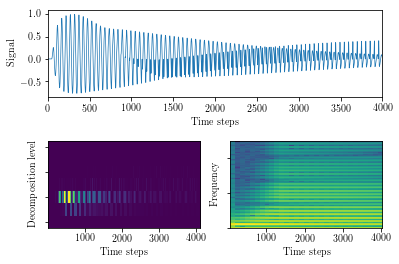

In [5]:
valid = valid1[i,:4096]
wt = pywt.Wavelet('db6')
level = 7
wavelet = pywt.wavedec(valid, wt, level=level)
wavelet_dec = np.square(wavelet)
wavelet_dec_1 = [np.concatenate([np.ones(2**(level-i+1))*j for j in k[:2**11//2**(level-i)]]) for i, k in enumerate(wavelet_dec) if i!=0]

wavelet_lin = np.hstack(wavelet_dec_1)

wavelet_dec_1 = np.flip(np.array(wavelet_dec_1), axis=0)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig=plt.figure()

gs=GridSpec(2,2) # 2 rows, 3 columns

ax1=fig.add_subplot(gs[1,0]) # First row, first column
ax2=fig.add_subplot(gs[1,1]) # First row, second column
ax3=fig.add_subplot(gs[0,:]) # Second row, span all columns

im = ax1.imshow(wavelet_dec_1)
ax1.set_aspect(aspect="auto")
im2 = ax2.specgram(valid, Fs=1)
ax3.plot(valid, linewidth=0.7)
ax2.set_xticks(np.array(np.array([1000, 2000, 3000, 4000])))
ax2.set_xticklabels(np.array([1000, 2000, 3000, 4000]))
ax1.set_xticks(np.array([1000, 2000, 3000, 4000]))
ax1.set_xticklabels([1000, 2000, 3000, 4000])
ax3.set_xlim(np.array([0, 4000]))
ax1.set_xlabel(r'Time steps')
ax1.set_ylabel(r'Decomposition level')
ax2.set_xlabel(r'Time steps')
ax2.set_ylabel(r'Frequency')
ax3.set_xlabel(r'Time steps')
ax3.set_ylabel(r'Signal')

ax2.set_yticklabels([])
ax1.set_yticklabels([])

gs.update(hspace=0.5)
fig.savefig('scalogram.pdf')

